# Анализ оттока клиентов сети фитнес-центров

**Задачи исследования:** 
 1) Составить прогноз вероятности оттока (на уровне следующего месяца) для каждого клиента;
 2) Сформировать типичные портреты клиентов, выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 3) Проанализировать основные признаки, наиболее сильно влияющие на отток;
 4) Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   - выделить целевые группы клиентов;
   - предложить меры по снижению оттока;
   - определить другие особенности взаимодействия с клиентами.

**Этапы исследования:**
1) Ознакомление с данными и проведение исследовательского анализа;
2) Построение модели прогнозирования оттока клиентов;
3) Кластеризация клиентов;
4) Вывод и рекомендации

**Описание данных:**

1 датасет - данные клиента за предыдущий до проверки факта оттока месяц\
2 датасет - информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента

### Знакомство с данными и EDA

In [29]:
# импортируем  необходимые библиотеки
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score
)

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
# устанавливаем отображение числа знаков после точки
pd.options.display.float_format = '{:.2f}'.format 
# устанавливаем отображение количества столбцов 
pd.options.display.max_columns = 40

In [32]:
# открываем файл
clients= pd.read_csv('/datasets/gym_churn.csv')

clients.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
5,1,1,0,0,1,1,1,34,450.74,1.00,3,2.62,2.64,0
6,1,1,1,1,0,6,1,32,94.27,6.00,2,1.14,1.28,0
7,0,1,0,0,1,1,0,30,217.79,1.00,0,1.21,1.05,1
8,1,1,1,1,1,1,1,23,45.41,1.00,1,1.11,1.06,0
9,0,1,0,0,1,1,0,31,65.31,1.00,11,1.81,1.95,0


In [33]:
# приведем названия столбцов к нижнему регистру
clients.columns = clients.columns.str.lower()

In [34]:
# посмотрим общую информацию
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [35]:
# проверим наличие дубликатов
clients.duplicated().sum()

0

Данные состоят из 4000 записей о клиентах, и включают 14 столбцов. Пропуски отсутствуют. Явных дубликатов не выявлено.


In [36]:
clients.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


Посмотрев общую информацию, можно сказать следующее:
- в выборке приблизительно поровну мужчин и женщин;
- большинство клиентов, порядка 85%, работают или проживают в районе фитнес центра, об этом свидетельствуют значения среднего на уровне 0,84 и первого квартиля 1;
- сотрудников компаний - партнеров и остальных клиентов примерно поровну;
- по акции "приведи друга" занимаются порядка 30% клиентов;
- контактный телефон предоставили порядка 90% клиентов;
- средняя длительность действующего абонемента составляет 4-5 месяцев в 25% случаев клиенты покупали более длительные абонементы (от 6 до 12 месяцев);
- групповыми тренировками пользуются менее половины клиентов, примерно 40%;
- возраст клиентов от 18 лет до 41 года, средний возраст клиента 29 лет;
- средняя суммарная выручка от дополнительных услуг составляет 147р.;
- в среднем у клиентов остаток срока абонемента наблюдаем на уровне 4 месяцев, однако у больше половины клиентов остался всего 1 оплаченный месяц занятий;
- имеются данные о клиентах, которые обращались в фитнес центр впервые от 0 до 31 месяца назад, среднее значение здесь наблюдаем на уровне 4 месяцев;
- в среднем за неделю клиенты посещают клуб дважды, однако есть и большие любители фитнеса, занимающиеся 6 раз в неделю;
- тех кто продолжает пользоваться услугами фитнес центра очевидно больше, в среднем ушли 27% клиентов 

In [37]:
# посмотрим средние значения в разбивке по оставшимся и ушедшим клиентам.
clients_1 = clients.groupby('churn').mean()
clients_1

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Выделим наиболее интересные наблюдения по средним значениям в полученных выборках:

- клиенты проживающие в районе фитнес центра чуть лояльнее (среди оставшихся 87% местных, среди ушедших 77% местных);
- клиенты, занимающиеся по партнерским программам уходят реже (среди оставшихся 53% сотрудники партнеров, среди ушедших 36%);
- аналогичное наблюдение по акции приведи друга (35% оставшихся пришли по рекомендации, среди ушедших 18% пользовались этой акцией);
- ушедшие клиенты в среднем приобретали абонементы на меньший срок;
- действующие клиенты в среднем чаще посещают групповые занятия (46% против 27% у ушедших);
- люди чаще остаются, если они пользуются еще и другими услугами;
- чем дольше человек занимается в одном конкретном фитнес-клубе (lifetime), тем меньше вероятность, что он оттуда перейдет в другой или забросит занятия;
- действующие клиенты ожидаемо совершают большее количество визитов (в среднем 2), а среднее количество визитов ушедших клиентов - 1.5 на всем периоде и 1 раз в неделю в текущем месяце.

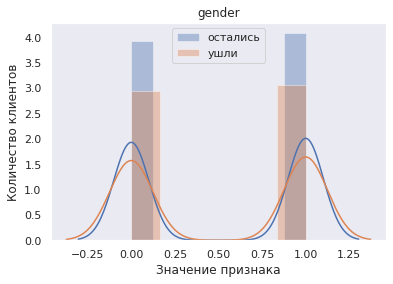

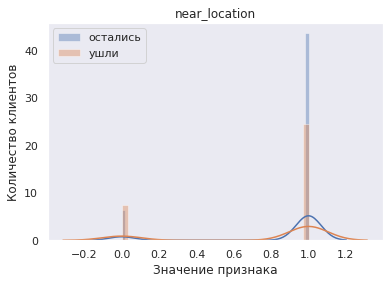

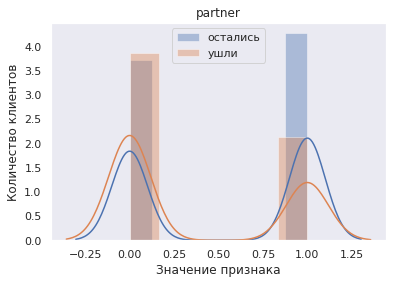

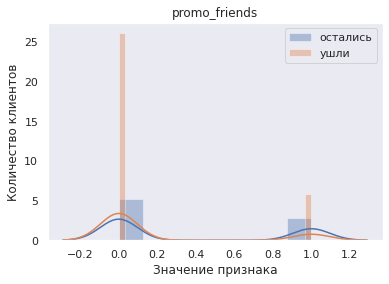

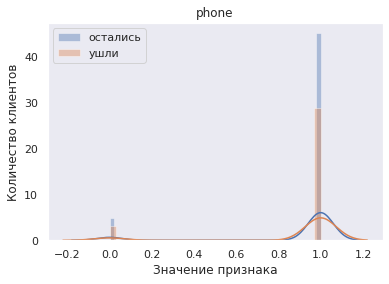

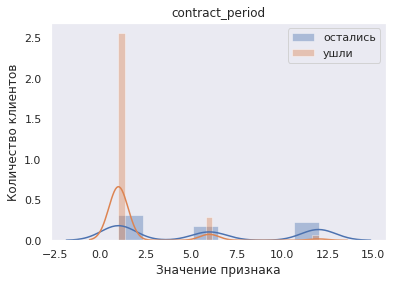

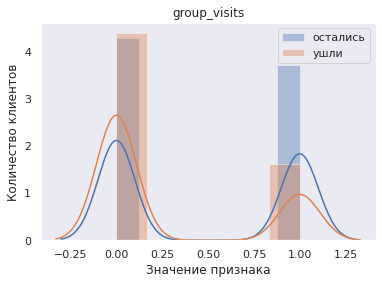

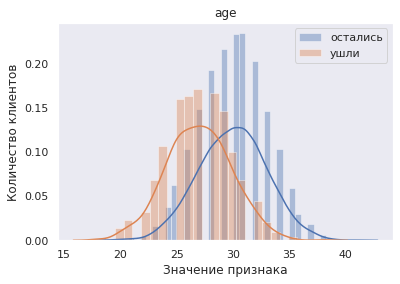

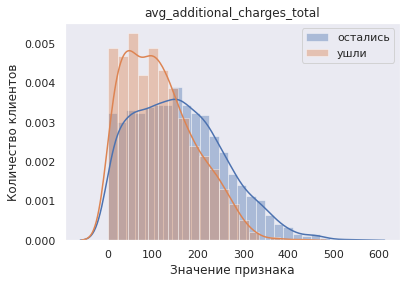

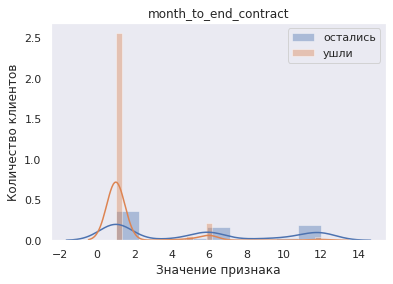

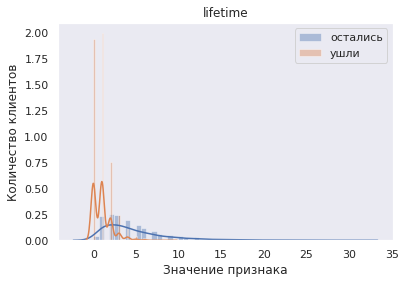

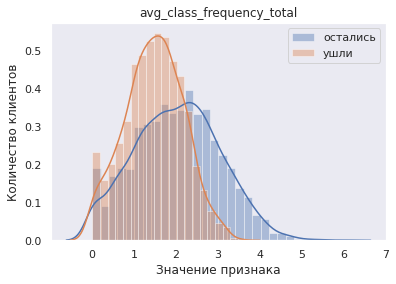

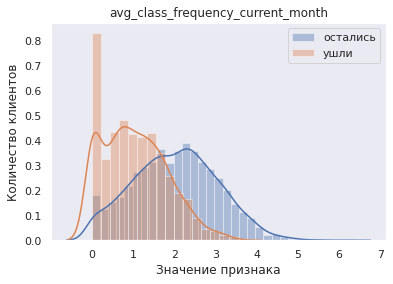

In [38]:
# Построим гистограммы и распределения признаков для тех, кто ушел и тех, кто остался
sns.set()
fig, ax_lst = plt.subplots(1, 1)

for i in clients.drop('churn', axis=1).columns:
    
    sns.distplot(clients.loc[clients['churn'] == 0, i], label='остались')
       
    sns.distplot(clients.loc[clients['churn'] == 1, i], label='ушли')
    
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение признака')
    plt.grid()
    plt.title(f'{i}')
    plt.legend()
    plt.show()

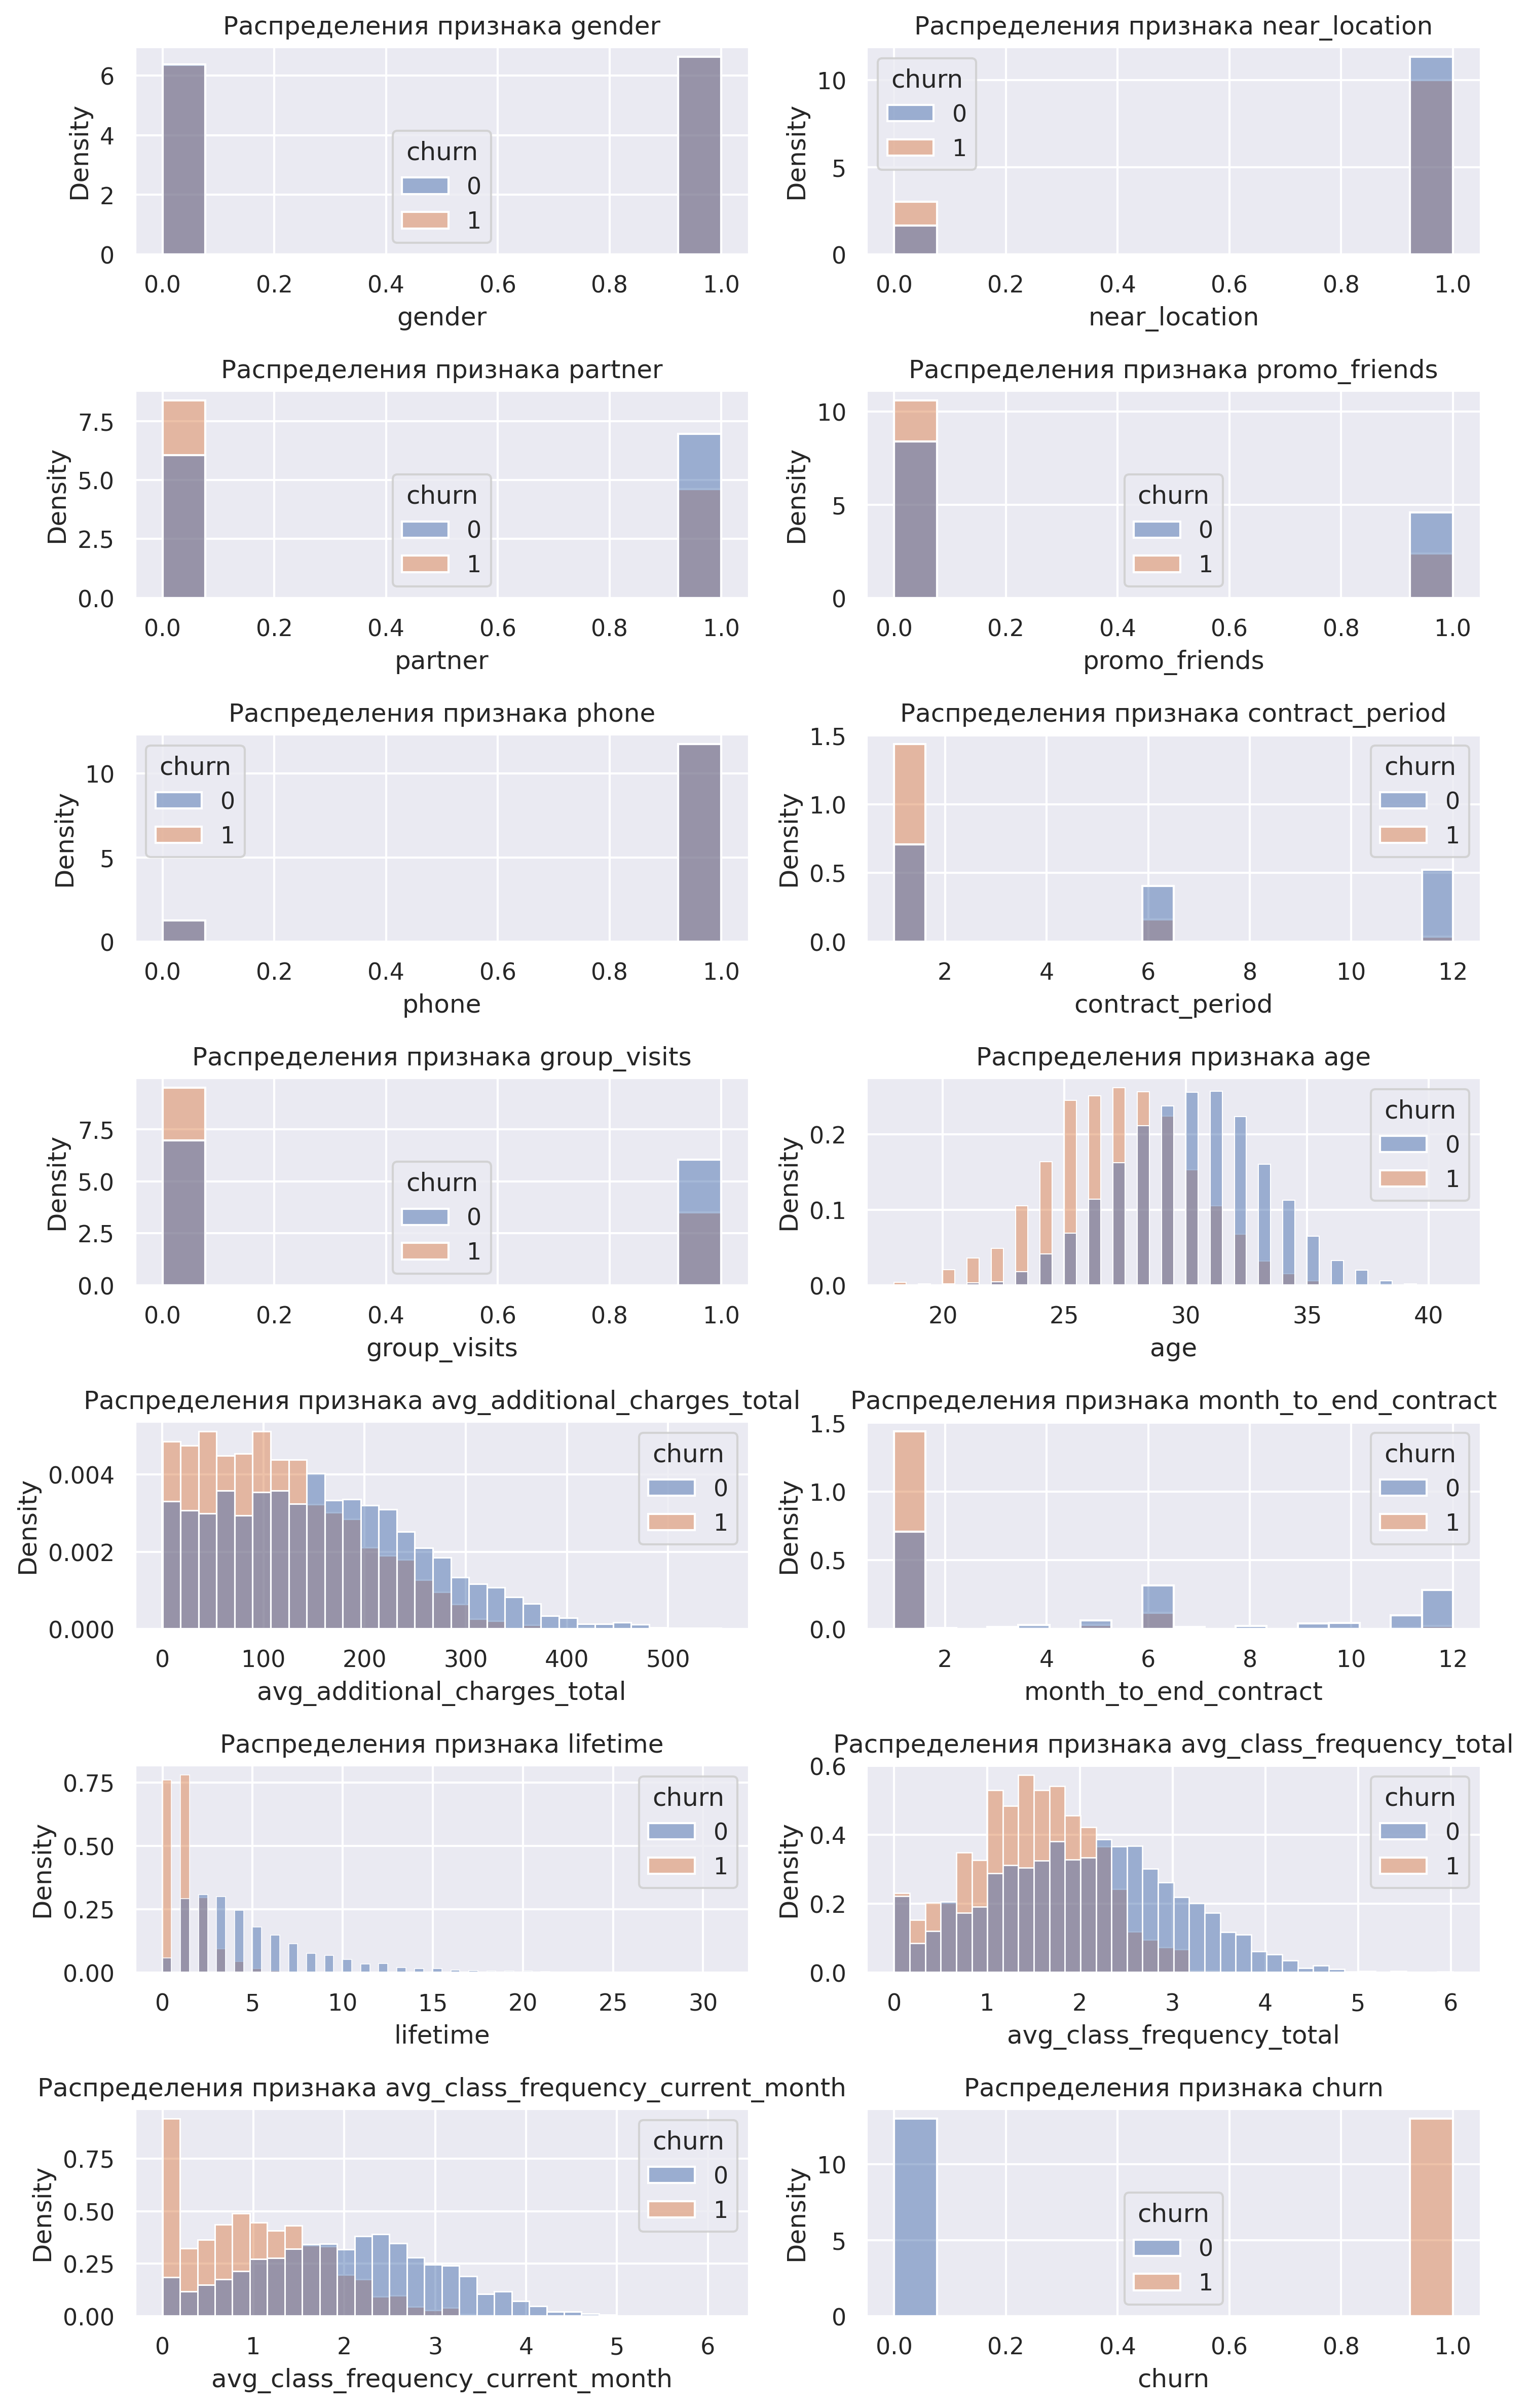

In [39]:
fig, axs = plt.subplots(len(clients.columns) // 2, 2)
fig.set_size_inches(10, 16) 
fig.set_dpi(300)

new_axs = [item for sublist in axs for item in sublist]

for i, column in enumerate(clients.columns):
    sns.histplot(data=clients, x=column, hue='churn',  stat='density', common_norm=False,  ax=new_axs[i])
    new_axs[i].set_title('Распределения признака {}'.format(column))

plt.tight_layout()
plt.show()


Выделим основные особенности, на основании графиков:

1) Меньший отток демонстрируют:\
сотрудники компаний партнеров;\
клиенты, проживающие в районе фитнес центра;\
клиенты с длительным сроком действия абонемента;\
клиенты посещающие групповые занятия;\
клиенты в возрасте от 28 лет.

2) Чаще уходят:\
клиенты по акции "приведи друга"\
клиенты со сроком действия абонемента менее 6 месяцев, в особенности краткосрочные - 1 месяц;\
клиенты в возрасте до 28 лет;\
те, кто не тратит либо тратит мало на доп. услуги;\
клиенты, у которых остается малый срок до конца срока действия абонемента;\
клиенты посещающие занятия реже двух раз в неделю.

3) Не наблюдается разницы:\
между мужчинами и женщинами;\
у не посещающих групповые занятия.

В большинстве случаев распределения можно считать нормальными. За исключением, пожалуй, распределений по продаже доп. услуг, времени с момента первого обращения и среднего числа посещений за последний месяц.

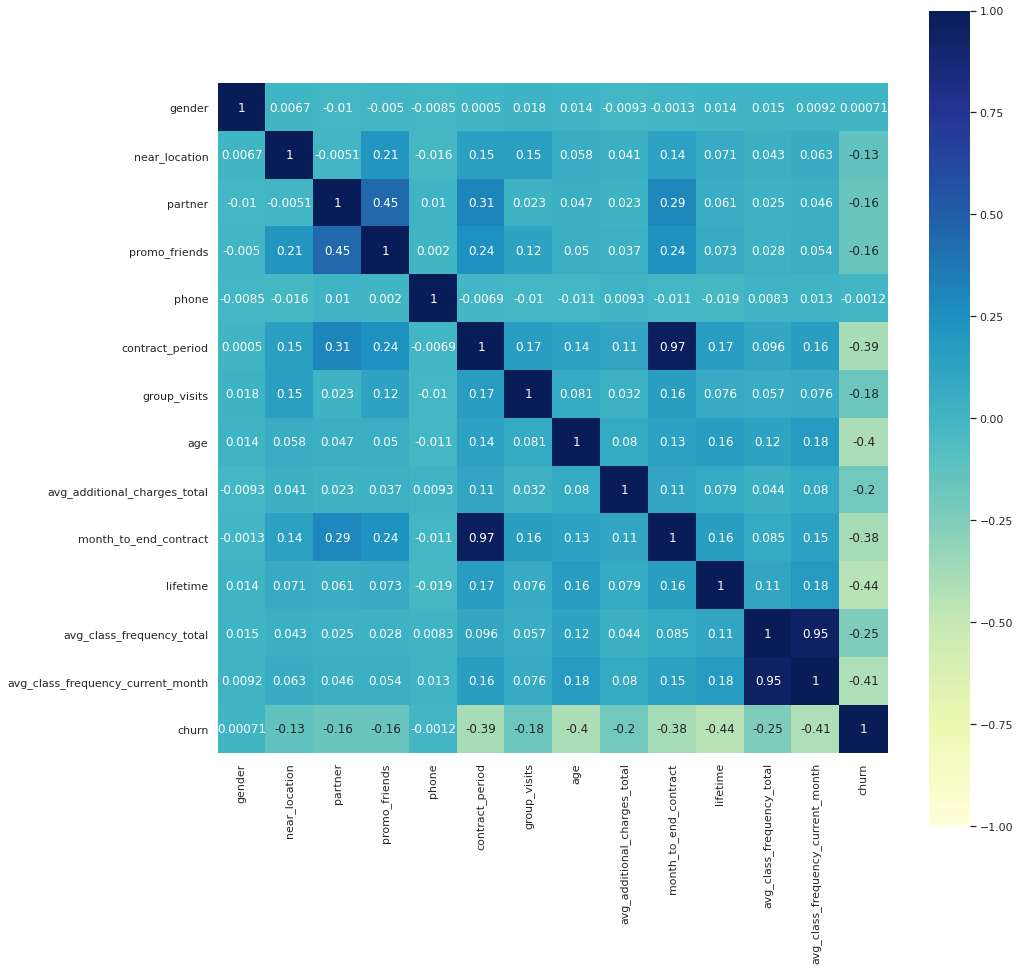

In [40]:
# посмотрим данные матрицы корреляций
corrMatrix = clients.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, annot = True, vmin=-1, vmax=1, center= 0, square=True, cmap="YlGnBu", )
plt.show()

Вывод:
- явной зависимости факта оттока от признаков не обнаружено;
- присутствует линейная зависимость между признаками - contract_period и month_to_end_contract, avg_class_frequency_current_month и avg_class_frequency_total, что очевидно;
- большинство признаков не связаны друг с другом.

Так как для построения модели прогнозирования не желательно наличие сильно скоррелированных показателей, уберем из выборки такие признаки.

In [41]:
model = clients.drop(['month_to_end_contract'], axis=1)

### Построение модели прогнозирования оттока клиентов

In [42]:
# создадим функцию, которая будет выводить метрики
def all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
  
    

In [43]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = model.drop('churn', axis=1)
y = model['churn'] 

In [44]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [45]:
# стандартизируем данные 
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 
X_test_st = scaler.transform(X_test)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [46]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [47]:
# зададим алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
# обучим модель 
rf_model.fit(X_train_st, y_train)
# воспользуемся обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.86
	Recall: 0.81


Вывод:\
На данном этапе были построены две модели прогнозирования оттока клиентов (логистическая регрессия, случайный лес)
и оценено их качество для данных с помощью метрик accuracy (доля правильных ответов), precision (точность), recall (полнота). По всем метрикам получены не плохие значения у обоих моделей, но чуть лучше демонстрирует себя "логистическая регрессия".
На основании полученных значений метрик, можно сказать, что обе модели показывают себя неплохо и способны делать приемлемые прогнозы.

### Kластеризация клиентов

In [48]:
# уберем столбец с оттоком клиентов
X = clients.drop('churn', axis=1)

In [49]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

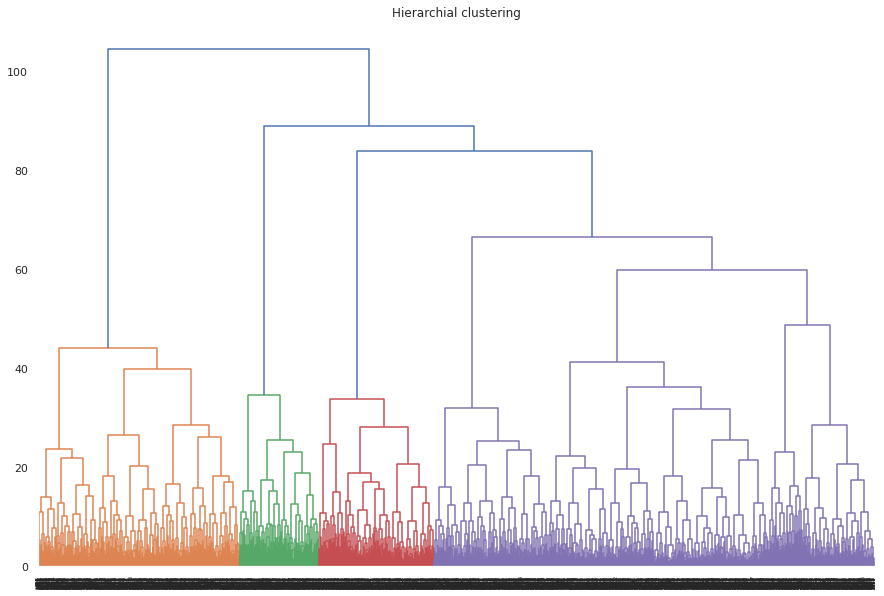

In [50]:
# Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()


По дендрограмме можно выделить от 4 до 6 кластеров. Согласно условию, установим число кластеров равным 5 для дальнейшего исследования.

In [51]:
# задаём модель k_means и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state=0) 
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)
# добавляем в исходные данные метки с номерами кластеров
clients['clusters'] = labels
clients.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,clusters
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0,1
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0,3
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0,3


In [52]:
# посмотрим средние значения метрик для каждого кластера
round (clients.groupby('clusters').mean().T, 2)


clusters,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


In [53]:
# посмотрим сколько клиентов попало в каждый кластер
clients['clusters'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: clusters, dtype: int64

На данном этапе можно сделать следующее описание кластеров:\
0 -  96% - живут поблизости, большой процент(78%) ходят по партнерской программе и 57% по рекомендации друзей, самая большая длительность абонементов (почти 11 месяцев) - вторая по численности группа;\
1 - самый малочисленный кластер - 86% живут поблизости, главное отличие кластера - никто из него не оставил свой номер телефона;\
2 - главная особенность - все живут далеко от фитнес-центра, очень низки процент(8%) пришедших по промокоду от друзей, и самый низкий % посещения групповых занятий(22%);\
3 - самая обширная группа - 100% живут близко, самый низкий период абонемента (примерно 2 месяца), меньше всего доп покупок, самый короткий срок с первого обращения в фитнес-центр(2,4 месяца), самая маленькая частота посещений в неделю (около 1, когда остальные - около 2);\
4 - выделяются тем, что средний возраст - 30 лет и среднее количество посещений в недели - около 3

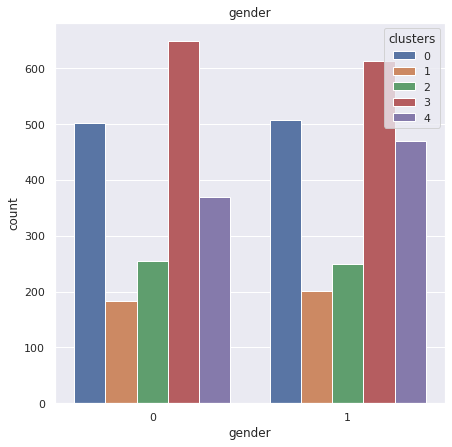

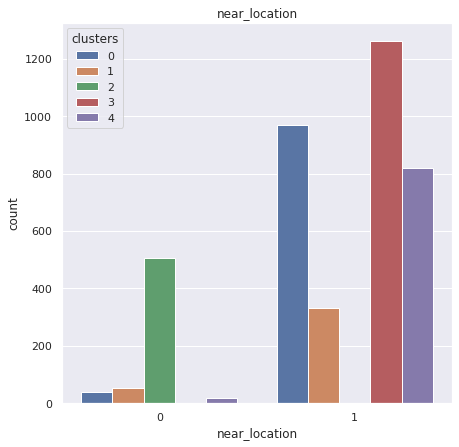

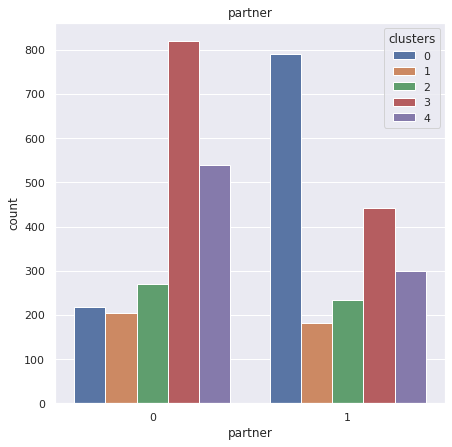

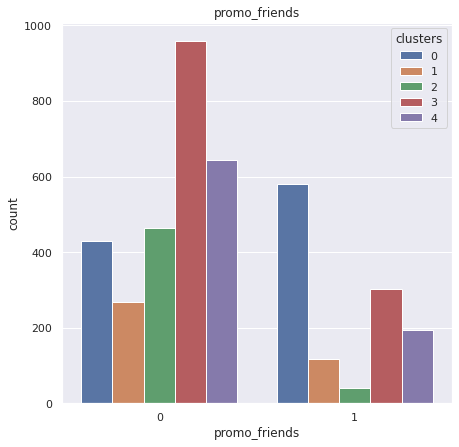

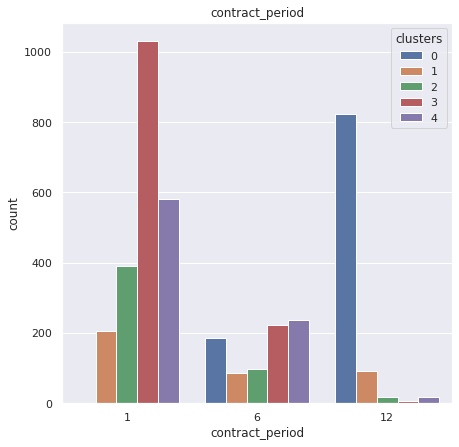

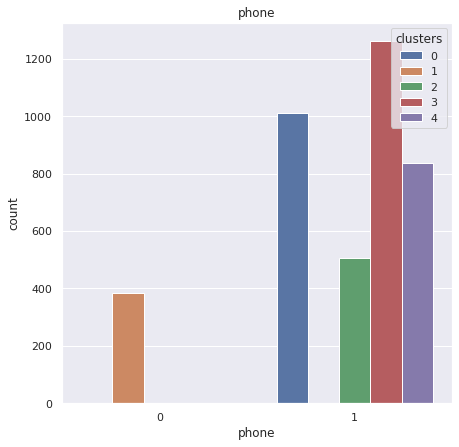

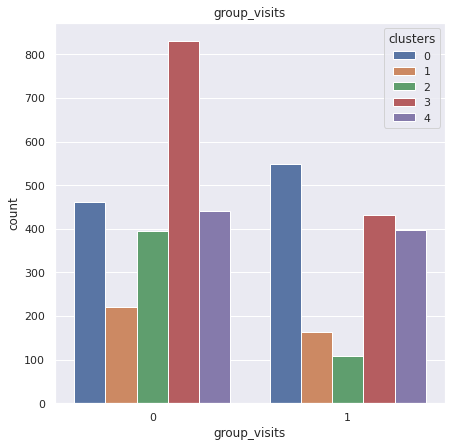

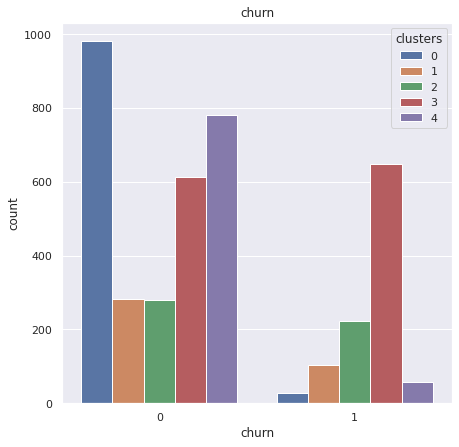

In [54]:
# построим графики распределния признаков для булевых значений
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period', 'phone', 'group_visits','churn']:
    plt.figure(figsize=(7, 7))
    sns.countplot(x = clients[column], hue='clusters', data=clients)
    plt.title(column)
    plt.show()

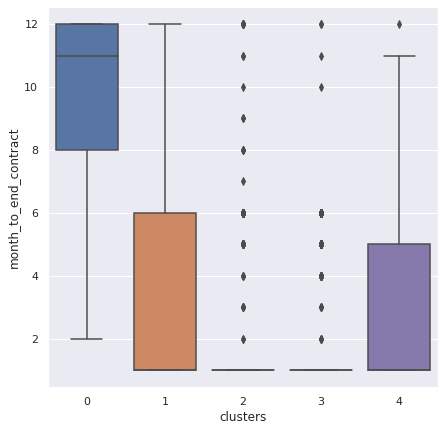

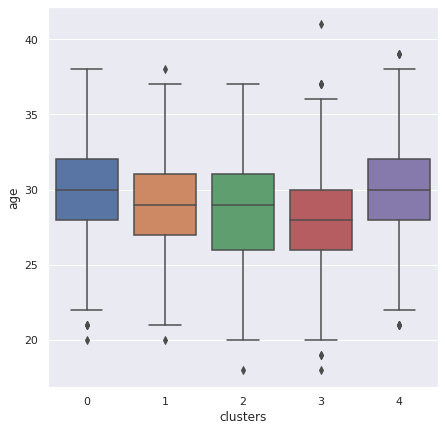

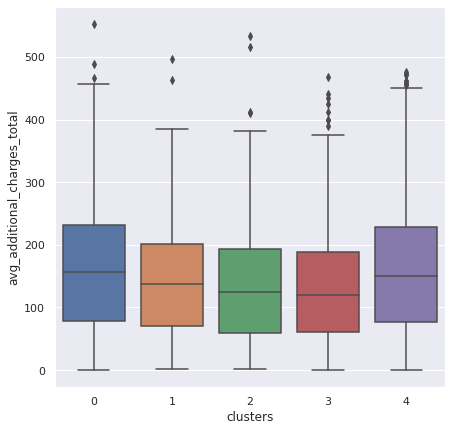

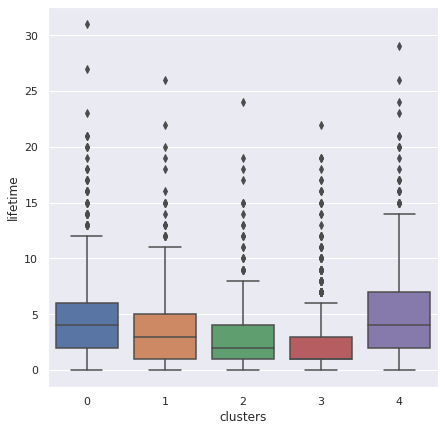

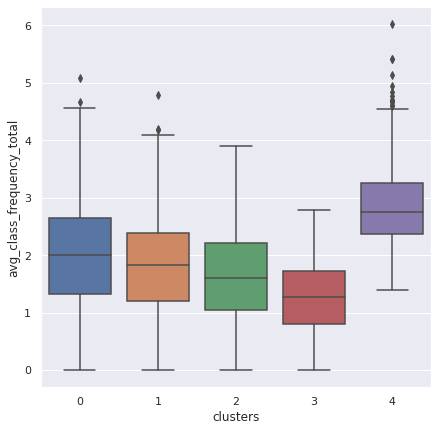

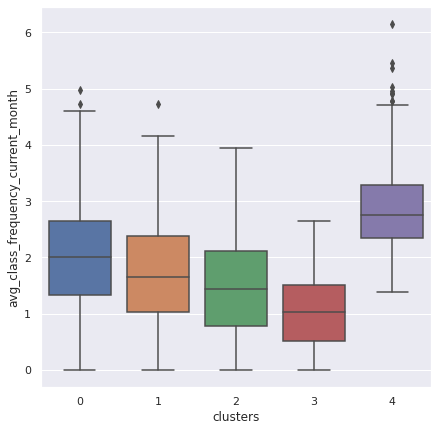

In [55]:
# построим графики распределния для остальных величин
for column in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(7, 7))
    sns.boxplot(x = 'clusters', y = clients[column], data =clients)
    plt.show()

Выделим основные маркеры характерные для кластеров по итогам построения графиков распределения:

**Кластер 0:**

В кластер 0 попали преимущественно следующие клиенты:\
проживающие рядом с фитнес - центром;\
сотрудники компаний-партнеров;\
имеющие длительные годовые абонементы;\
возраст около 30;\
относительно много тратящие на доп. услуги;\
посещающие занятия в среднем дважды в неделю;\
чуть чаще посещающие групповые занятия;\
с самой низкой долей оттока.

**Кластер 1:**

В кластер 1 попали преимущественно следующие клиенты:\
проживающие не далеко от фитнес - центра;\
доля сотрудников партнеров и остальных почти поровну и невысокая доля пришедших по рекомендации;\
не предоставившие номер телефона;\
срок абонемента чаще всего 1 месяц;\
реже посещающие групповые занятия;\
средний возраст ниже 30;\
в среднем реже 2 раз в неделю посещающие занятия;\
небольшая доля оттока.

**Кластер 2:**

В кластер 2 попали следующие клиенты:\
проживающие далеко от фитнес - центра;\
не по акции "приведи друга";\
короткие абонементы чаще 1 месяц;\
реже посещающие групповые занятия;\
возраст ниже 30;\
в среднем реже 2 раз в неделю посещающие занятия;\
достаточно высокая доля оттока.

**Кластер 3:**

В кластер 3 попали клиенты:\
проживающие рядом;\
краткосрочные абонементы;\
реже посещающие групповые занятия;\
самые молодые (около 27-28);\
редко бывающие в зале чаще 1 раза в неделю;\
меньшая часть в этом кластере участники партнерской либо "дружеской" акций;\
самая высокая доля оттока.

**Кластер 4:**

В кластер 4 попали преимущественно клиенты:\
проживающие рядом;\
возраст около 30;\
в среднем чаще 2 раз в неделю посещающие клуб;\
активно покупающие доп. услуги;\
со средним либо краткосрочным абонементом;\
меньшая часть в этом кластере участники партнерской либо "дружеской" акций;\
не высокая доля оттока

In [56]:
# для каждого полученного кластера посчитаem долю оттока
df = clients.query('churn==1').groupby('clusters')['churn'].count() / clients.query('churn==1')['churn'].count()
df

clusters
0   0.03
1   0.10
2   0.21
3   0.61
4   0.05
Name: churn, dtype: float64

Как и предполагалось Кластер 0 показывает лучшие результаты по оттоку клиентов 3%, не плохие показатели у кластера 4 на уровне 5%. Ключевые черты характерные для этих кластеров можно использовать для построение портрета нашего "идеального" лояльного клиента. Это человек в возрасте около 30 лет, проживающий рядом, посещающий зал 2 иногда 3 раза в неделю, любитель групповых занятий и пользующийся доп услугами, владелец годового абонемента, чаще всего сотрудник компании-партнера.

Худшие показатели у кластеров 3 и 2 (61% и 21% соответственно), аналогично ключевые черты характерные для этих кластеров можно использовать для построение портрета потенциально уходящего клиента. Это человек моложе 30 лет, проживающий далеко от клуба, посещающий клуб не чаще раза в неделю, владелец краткосрочного абонемента, не склонный к групповым занятиям.

### Общий вывод


В работе были проанализированы данные клиентов фитнес центра.\
На основании имеющихся данных были построены две модели прогнозирования оттока клиентов:\
-логистическая регрессия\
-случайный лес\
Основываясь на показаниях ключевых метрик оценки моделей accurancy, precision и recall можно сказать, что обе модели хорошо показывает себя в прогнозировании оттока. По совокупности чуть лучше показывает себя модель "логистическая регрессия".

Далее была проведена кластеризация клиентов, выборку разделили на 5 кластеров.Кластер 0 показывает лучшие результаты по оттоку клиентов 3%, не плохие показатели у кластера 4 на уровне 5%. По ключевым характеристикам этих кластеров можно сказать, что  "идеальный" клиент - это человек в возрасте около 30 лет, проживающий рядом, посещающий зал 2 иногда 3 раза в неделю, любитель групповых занятий и пользующийся доп услугами, владелец годового абонемента, чаще всего сотрудник компании-партнера.\
Худшие показатели у кластеров 3 и 2 (61% и 21% соответственно),таким образом, потенциально уходящий клиент - это человек моложе 30 лет, проживающий далеко от клуба, посещающий клуб не чаще раза в неделю, владелец краткосрочного абонемента, не склонный к групповым занятиям.


*Рекомендации:*

Рекомендации для каждой группы клиентов:

**Кластер 0 и 4:**\
Это самые лояльные группы клиентов. Для сохранения заинтересованности таких клиентов, следует разработать программы лояльности. Так как эти группы активно пользуется дополнительными услугами необходимо разнообразить и увеличить число таких предложений.

**Кластер 1 и 3:**\
Это молодые люди (моложе 30), проживающие рядом, с короткими абонементами и редким посещением занятий, в том числе и групповых. Необходимо работать в этой группе на увеличение продаж более длительных абонементов (например, "студенческие скидки" и т.п.), мотивировать действующих клиентов на регулярные (2-3 раза в неделю) посещения. Активнее предлагать и по возможности разнообразить групповые тренировки. Т.к. клиент, регулярно занимающийся в группе менее склонен к оттоку.
В кластер 1 вошли клиенты, которые не предоставили номер телефона - стоит усовершенствовать сбор данных, позволяющих связываться с клиентом для получния обратной связи и рассылки предложений. Например, добавить в анкету информацию о мессенджерах и эл.почте.
 
**Кластер 2:**\
В этой группе довольно высокий отток. Это молодые люди, проживающие далеко от фитнес центра. Им также можно предложить программы лояльности и доп.услуги, которые будут компенсировать расположение фитнес клуба. Возможно эти клиенты работают или учатся рядом, тогда можно поработать над расширением партнерских программ с близлежащими организациями. 

**Общие рекомендации:**
1) Проводить маркетинговые активности, направленные на целевую аудиторию:
- акцент на рекламу в близлежащих районах;
- реклама должна нести в себе ценности близкие и понятные человеку в возрасте 30+ (например, стабильность, забота о здоровье, восстановление/поддержание хорошей фигуры/формы, высокое качество тренажёров/услуг/программ и т.п.);

2) Акции:
- не прекращать и наращивать партнерскую программу в организациях, т.к. клиенты из компаний партнеров менее склонны к оттоку;
- акция "приведи друга" также показывает себя хорошо.